In [5]:
# Standard Library Imports
import struct
import sys
import serial
import binascii
import time
import os
import datetime
import math

# Third-Party Library Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm  # Adding colormap import
from mpl_toolkits.mplot3d import Axes3D
from scipy.signal import find_peaks, savgol_filter
from scipy.interpolate import interp1d
from sklearn.datasets import make_blobs

# Local File Imports
from parse_bin_output import *
from kmeans import *


In [7]:
# Applies a moving average to smooth the data.
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='same')

# Removes outliers based on the Interquartile Range method.
def remove_outliers_iqr(data):
    Q1 = np.percentile(data, 25, axis=0)
    Q3 = np.percentile(data, 75, axis=0)
    IQR = Q3 - Q1
    outlier_mask = ((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR)))
    return data[~np.any(outlier_mask, axis=1)]

# Finds the closest centroid from a set of centroids.
def find_closest_centroid(current_centroid, centroids, exclude_index=None):
    distances = np.linalg.norm(centroids - current_centroid, axis=1)
    if exclude_index is not None:
        distances[exclude_index] = np.inf 
    return np.argmin(distances)

# Checks for dual clusters in a data array.
def check_for_dual_cluster(arr):
    arr = remove_outliers_iqr(arr)  # Remove outliers
    clf = Kmeans(k=2)  # Assume Kmeans and its predict method are defined
    labels, centroids = clf.predict(arr)
    if np.any(np.isnan(centroids)):
        return False
    dist = np.linalg.norm(centroids[1] - centroids[0])
    return dist > 2.2 if dist != np.nan else False
    
# Calculates the angle between three points.
def calculate_angle(A, B, C):
    AB = (B[0] - A[0], B[1] - A[1])
    BC = (C[0] - B[0], C[1] - B[1])
    dot_product = AB[0] * BC[0] + AB[1] * BC[1]
    magnitude_AB = math.sqrt(AB[0]**2 + AB[1]**2)
    magnitude_BC = math.sqrt(BC[0]**2 + BC[1]**2)
    angle_radians = math.acos(dot_product / (magnitude_AB * magnitude_BC))
    return math.degrees(angle_radians)

# Calculates the angle between points in a larger window.
def calculate_angle_large_window(window):
    if len(window) >= 10:
        return calculate_angle(window[0], window[4], window[9])
    return 0

# Checks if a frame index is within an 'on' segment.
def is_on_segment(i, switchpoints):
    for j in range(0, len(switchpoints), 2):
        start = 0 if j == 0 else switchpoints[j - 1]
        end = switchpoints[j]
        if start <= i < end:
            return True
    return False

# Determines on/off switchpoints in the dataset.
def onoff(output_dict):
    num_frames = len(output_dict)
    tmp = 0
    closest_peak_ranges = []
    nFFT = len(output_dict[0]['rangeProfile'])
    fs = 100e6 / 8
    c0 = 3e8
    S = 170e12
    dmax = fs * c0 / (4 * S)
    delta_d = dmax / nFFT
    for frame_num in range(num_frames):
        range_profile = output_dict[frame_num]['rangeProfile']
        peaks, _ = find_peaks(range_profile, distance=5, threshold=np.std(range_profile) * 2)
        if len(peaks) != 0:
            closest_peak_ranges.append(peaks[0] * delta_d)
            tmp = peaks[0] * delta_d
        else:
            closest_peak_ranges.append(tmp)
    df = pd.DataFrame(closest_peak_ranges)
    slop = df.diff()
    peaks = (slop <= -2 * np.std(slop)) * 1
    indices = peaks.loc[peaks[0] == 1].index
    filtered_indices = []
    for index in indices:
        if not filtered_indices or index - filtered_indices[-1] > 5:
            filtered_indices.append(index)
    return filtered_indices

In [3]:
# Assuming parse_ADC and output_dict are defined as before
binDirPath = "/Users/cyin/Documents/cs437/lab4/Industrial_Visualizer/binData/12_07_2023_14_13_41"
output_dict = parse_ADC(binDirPath)

processing file: /Users/cyin/Documents/cs437/lab4/Industrial_Visualizer/binData/12_07_2023_14_13_41/pHistBytes_1.bin


[32, 39, 47]
[20, 20, 20]
69
69


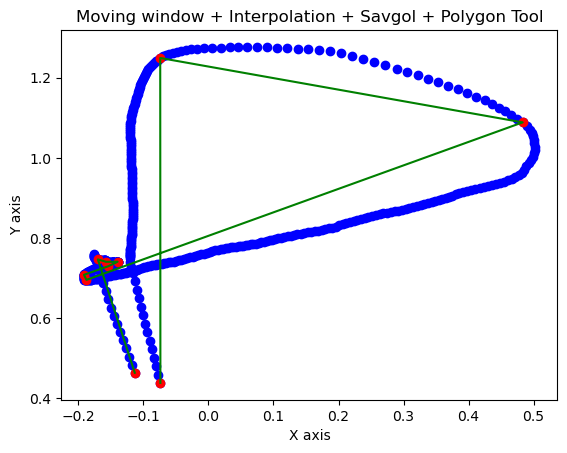

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


69


In [6]:
#main function
def draw(output_dict, num_frames=100):
    plt.close()  # Close any existing figures
    
    #pen status
    status = False
    
    switchpoints = onoff(output_dict)
    
    print((switchpoints))
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111)
    thres = 0.2
  
    window_size=5
    centroid_x1, centroid_y1, centroid_z1, colors1 = [], [], [], []

    object1, object2 = None, None

    # Axis limits
    axis_limits = (-1.5, 1.5)
    axis_limits1 = (-1, 1)
    last_selected_point = None  
    
    loc_frame = []

    for framenum in range(num_frames):
        try:
            xyz = output_dict[framenum]['pointCloud'][:,0:3]
        except KeyError:
            continue
            
#         if check_for_dual_cluster(xyz):
#             print("dual cluster detected", framenum)
#             continue
        distances = np.linalg.norm(xyz, axis=1)
        
        
#         if framenum in switchpoints:
#             status = not status
        
#         print(framenum, status)
#         if status == False:
#             continue
        
        
        within_threshold_indices = distances > 0.05
        xyz = xyz[within_threshold_indices]
        distances = np.linalg.norm(xyz, axis=1)

        # Find the index of the point closest to the origin
    
        closest_point_index = np.argmin(distances)

        # Get the coordinates of the closest point
        xyz = xyz[closest_point_index]
        current_point = xyz
        if framenum in switchpoints:
            loc_frame.append(len(centroid_x1)-1)
        
        if last_selected_point is None or np.linalg.norm(current_point - last_selected_point) <= 0.3:
            last_selected_point = current_point
            centroid_x1.append(xyz[0])
            centroid_y1.append(xyz[1])
            centroid_z1.append(xyz[2])
            colors1.append(framenum)
        else:
            continue
    print(loc_frame)

    norm = plt.Normalize(0, num_frames)
    cmap = cm.viridis
    print(len(centroid_x1))
    if len(centroid_x1) > 1:


        centroid_x1 = moving_average(centroid_x1, window_size)
        centroid_y1 = moving_average(centroid_y1, window_size)
        
        print(len(centroid_x1))
        frames = np.arange(len(centroid_x1))
        interp_func_x = interp1d(frames, centroid_x1, kind='linear')
        interp_func_y = interp1d(frames, centroid_y1, kind='linear')
        
        # Create a dense range of points for interpolation
        dense_frames = np.linspace(0, frames[-1], num=500)
        interp_x = interp_func_x(dense_frames)
        interp_y = interp_func_y(dense_frames)

        # Apply smoothing to the interpolated data
#         interp_x = moving_average(interp_x, window_size)
#         interp_y = moving_average(interp_y, window_size)
        
        window_length = 5
        polyorder = 1
        smoothed_x = savgol_filter(interp_x, window_length, polyorder)
        smoothed_y = savgol_filter(interp_y, window_length, polyorder)

        # Plot the smoothed interpolated trace
        #ax1.plot(smoothed_x, smoothed_y, label='Pen trace')
        
        
        
        x = smoothed_x
        y = smoothed_y

        marked_points_large_window = [(x[0],y[0])]
        
        i = 0
        while i < len(x) - 9:
            window = list(zip(x[i:i+10], y[i:i+10]))
            angle = calculate_angle_large_window(window)
            angle = 180 - angle
            invalg = 360 - angle
            diff = abs(angle - invalg)
    
          
            if  42<diff :
                # Mark the 5th point in the window
                marked_points_large_window.append(window[4])
                i += 25  # Move to the next window without overlap
            else:
                i += 1
        marked_points_large_window.append((x[-1],y[-1]))
        # Plotting
        plt.scatter(x, y, color='blue')  # Plot all points
        plt.scatter(*zip(*marked_points_large_window), color='red')  # Plot marked points

        # Connect marked points with a line
        if marked_points_large_window:
            mx, my = zip(*marked_points_large_window)
            plt.plot(mx, my, color='green')

        plt.xlabel('X axis')
        plt.ylabel('Y axis')
        plt.title('Moving window + Interpolation + Savgol + Polygon Tool')
        plt.show()



    

 
    print(len(centroid_x1))
    #sc1 = ax1.scatter(centroid_x1, centroid_y1, c=colors1, cmap=cmap, norm=norm, marker='o', label='Object 1 Trace')
#     ax1.scatter(centroid_x1, centroid_y1,c=colors1, cmap=cmap, label='Smoothed Interpolated Trace')
    
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_xlim(axis_limits)
    ax1.set_ylim(axis_limits)
    ax1.legend()


    plt.show()

draw(output_dict, num_frames=100)
